# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv
import os
import glob


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    dff = df.copy()
    
    first=True
    
    for col in dff.filter(regex='sample').columns:
        
        col_gene_name = col + "_total_gene_expression"
        col_relative_abundance = col + "_relative_abundance"
    
        dff_sums = dff[["gene_id", col]].groupby("gene_id").sum()

        dff_sums[col_gene_name] = dff_sums[col].copy()

        dff_sums.drop(columns=col, inplace=True)

        if first:
            merged_dff = pd.merge(dff, dff_sums, how='inner', on="gene_id")
            merged_dff[col_relative_abundance] = ((merged_dff[col]/merged_dff[col_gene_name]) * 100)
            
        else:
            merged_dff = pd.merge(merged_dff, dff_sums, how='inner', on="gene_id")
            merged_dff[col_relative_abundance] = ((merged_dff[col]/merged_dff[col_gene_name]) * 100)
        
        first=False
        
    merged_dff.fillna(value=0, inplace=True)
        
    return merged_dff

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    dff = df.copy()
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = dff.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        dff["gene_id"] = dff.index
        cols = list(dff.columns)
        cols = [cols[-1]] + cols[:-1]
        dff = dff[cols]
        dff.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = dff.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    dff.columns = list_new_names
    
    return dff 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):
    
    dff = df.copy()

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = dff.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = dff.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    cpm_columns = {}

    for col in count_columns:
        rounded_col = round(dff[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        cpm_columns[cpm_name] = round(((rounded_col/(rounded_col.sum())) * 1000000), 2)

    new_data = {**dff.round(2).to_dict(orient='series'), **cpm_columns}
    dff = pd.DataFrame(new_data)

    return dff

In [49]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

## Import data and pre-process

In [6]:
## Import data

df_qpcr = pd.read_csv("../../../data/raw/RT-qPCR/cyc1_RT-qPCR.csv")

df_ont = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", sep="\t")

In [7]:
## Fix column names and calculate CPM
df_ont = fix_column_names(df_ont, is_gene=False)
df_ont = calculate_cpm(df_ont, is_gene=False)

In [8]:
## Drop counts columns
df_ont.drop(columns=df_ont.filter(regex="counts").columns, inplace=True)

In [9]:
## Rename samples from long-read sequencing

for col in df_ont.columns:
    if col.startswith("sample"):
        df_ont.rename(columns={col: col.split("_PA")[0]}, inplace=True)

In [10]:
## Drop useless stuff from qPCR

df_qpcr.drop(columns=["Unnamed: 9", "Unnamed: 10"], inplace=True)

df_qpcr.dropna(inplace=True)

In [11]:
## Fix sample column

df_qpcr["Sample"] = "sample_" + df_qpcr["Sample "].astype(str).str.split(".", expand=True)[0]

df_qpcr.drop(columns="Sample ", inplace=True)

In [12]:
## Transverse qPCR dataframe

df_qpcr_T = df_qpcr.drop(columns="Sample").T
df_qpcr_T.columns = df_qpcr["Sample"].to_list()
df_qpcr = df_qpcr_T.copy()

In [13]:
## Only keep relevant transcript on ONT data

trascript_list = ["BambuTx1879", "ENST00000361661", "ENST00000378069", "ENST00000622731",
                                     "BambuTx1845", "BambuTx1847", "ENST00000387347", "BambuTx1322"]

df_ont = df_ont.loc[df_ont["transcript_id"].isin(trascript_list)].copy()

In [14]:
## Create dataframe with relevant information

transcripts_dict = {"transcript_id": ["BambuTx1879", "ENST00000361661", "ENST00000378069", "ENST00000622731",
                                     "BambuTx1845", "BambuTx1847", "ENST00000387347", "BambuTx1322"],
                   "gene_id": ["ENSG00000069535", "ENSG00000145217", "ENSG00000069535", "ENSG00000145217",
                              "ENSG00000210082", "ENSG00000210082", "ENSG00000210082", "ENSG00000145217"],
                   "gene_name": ["MAOB", "SLC26A1", "MAOB", "SLC26A1",
                                "MT-RNR2", "MT-RNR2", "MT-RNR2", "SLC26A1"]}

df_transcript_info = pd.DataFrame(data=transcripts_dict)

In [15]:
## Make transcript_id a column of qPCR dataframe
df_qpcr.reset_index(names="transcript_id", inplace=True)

In [16]:
## drop gene_id in ONT dataframe

df_ont.drop(columns="gene_id", inplace=True)

In [17]:
## Add gene name and transcript name information to dataframe

df_qpcr = df_qpcr.merge(df_transcript_info, on="transcript_id", how="inner")

df_ont = df_ont.merge(df_transcript_info, on="transcript_id", how="inner")

In [18]:
df_ont.head()

,transcript_id,sample_579,sample_1131,sample_1218,sample_1304,sample_1271,sample_5356,sample_1163,sample_5295,sample_5292,sample_1092,sample_1186,sample_1291,gene_id,gene_name
0,BambuTx1322,1.47,0.49,1.63,0.68,0.53,1.14,1.75,2.91,0.54,1.47,0.72,5.45,ENSG00000145217,SLC26A1
1,BambuTx1845,37.63,1.07,18.76,1.65,43.42,1.31,54.74,101.16,39.21,7.53,14.25,41.55,ENSG00000210082,MT-RNR2
2,BambuTx1847,277.92,11.42,122.55,60.76,115.28,79.00,179.48,428.53,151.97,74.96,106.54,155.12,ENSG00000210082,MT-RNR2
3,BambuTx1879,4.30,1.29,6.71,0.68,4.76,2.47,6.17,6.16,6.73,3.43,0.54,15.40,ENSG00000069535,MAOB
4,ENST00000361661,0.01,2.18,0.00,0.34,0.04,0.73,0.06,0.06,0.18,0.08,0.36,0.04,ENSG00000145217,SLC26A1


In [19]:
## Calculate relative abundance

df_qpcr = relative_transcript_abundance(df_qpcr)

df_ont = relative_transcript_abundance(df_ont)

In [20]:
## Create melted dataframe for ONT

drop_columns_ont =  df_ont.filter(regex="total").columns.to_list()

drop_columns_ont = drop_columns_ont + ["sample_579","sample_1131", "sample_1218", "sample_1304", 
                                                        "sample_1271", "sample_5356", "sample_1163", "sample_5295", 
                                                        "sample_5292", "sample_1092", "sample_1186", "sample_1291"]


df_ont_melted = df_ont.drop(columns=drop_columns_ont)

df_ont_melted = df_ont_melted.melt(id_vars=['gene_id', "gene_name", "transcript_id"],
                                   var_name='Sample', value_name='relative_abundance')

In [24]:
## Create melted dataframe for qpcr

drop_columns_qpcr =  df_qpcr.filter(regex="total").columns.to_list()

drop_columns_qpcr = drop_columns_qpcr + ["sample_579","sample_1131", "sample_1218", "sample_1304", 
                                                        "sample_1271", "sample_1163", "sample_5295", 
                                                        "sample_1291"]


df_qpcr_melted = df_qpcr.drop(columns=drop_columns_qpcr)

df_qpcr_melted = df_qpcr_melted.melt(id_vars=['gene_id', "gene_name", "transcript_id"],
                                   var_name='Sample', value_name='relative_abundance')

In [25]:
df_ont_melted["technology"] = "Long-reads"

df_qpcr_melted["technology"] = "RT-qPCR"

In [26]:
final_df = pd.concat([df_ont_melted, df_qpcr_melted])

In [30]:
final_df_maob = final_df.loc[final_df["gene_name"] == "MAOB"].copy()

In [32]:
final_df_slc26a1 = final_df.loc[final_df["gene_name"] == "SLC26A1"].copy()

In [34]:
final_df_mt = final_df.loc[final_df["gene_name"] == "MT-RNR2"].copy()

## Make plots

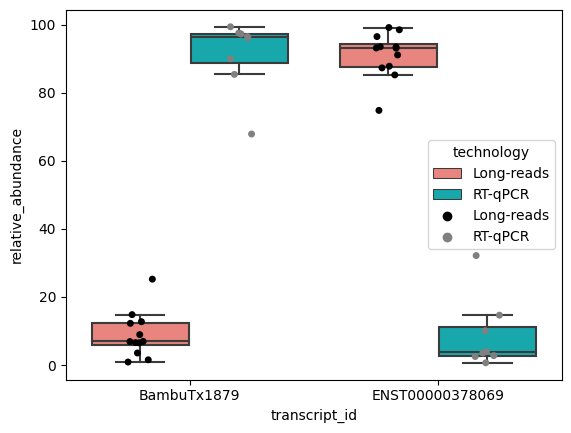

In [51]:
ax1 = sns.boxplot(final_df_maob, x="transcript_id", y="relative_abundance", hue="technology", fliersize=0, 
                  palette=[ggplot2_colors[0], ggplot2_colors[4]])

ax2 = sns.stripplot(final_df_maob, x="transcript_id", y="relative_abundance", hue="technology", dodge=True,
             palette=["black", "grey"], jitter=True)

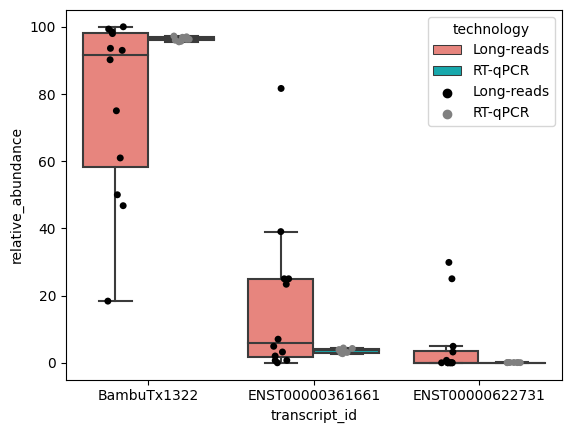

In [52]:
ax1 = sns.boxplot(final_df_slc26a1, x="transcript_id", y="relative_abundance", hue="technology", fliersize=0,
                 palette=[ggplot2_colors[0], ggplot2_colors[4]])

ax2 = sns.stripplot(final_df_slc26a1, x="transcript_id", y="relative_abundance", hue="technology", dodge=True,
             palette=["black", "grey"], jitter=True)

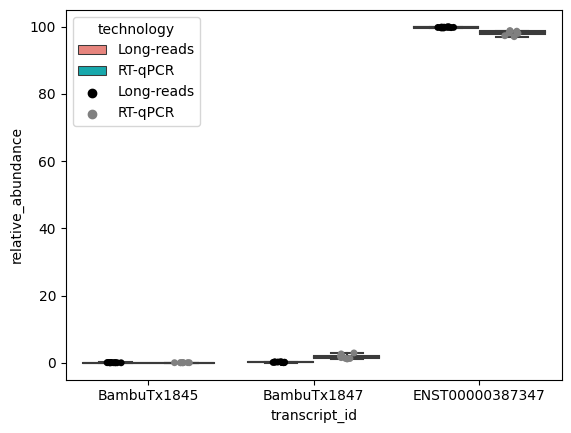

In [53]:
ax1 = sns.boxplot(final_df_mt, x="transcript_id", y="relative_abundance", hue="technology", fliersize=0,
                 palette=[ggplot2_colors[0], ggplot2_colors[4]])


ax2 = sns.stripplot(final_df_mt, x="transcript_id", y="relative_abundance", hue="technology", dodge=True,
             palette=["black", "grey"], jitter=True)

In [54]:
final_df_maob

,gene_id,gene_name,transcript_id,Sample,relative_abundance,technology
6,ENSG00000069535,MAOB,BambuTx1879,sample_579_relative_abundance,6.888818,Long-reads
7,ENSG00000069535,MAOB,ENST00000378069,sample_579_relative_abundance,93.111182,Long-reads
14,ENSG00000069535,MAOB,BambuTx1879,sample_1131_relative_abundance,1.543801,Long-reads
15,ENSG00000069535,MAOB,ENST00000378069,sample_1131_relative_abundance,98.456199,Long-reads
22,ENSG00000069535,MAOB,BambuTx1879,sample_1218_relative_abundance,12.248996,Long-reads
23,ENSG00000069535,MAOB,ENST00000378069,sample_1218_relative_abundance,87.751004,Long-reads
30,ENSG00000069535,MAOB,BambuTx1879,sample_1304_relative_abundance,0.885647,Long-reads
31,ENSG00000069535,MAOB,ENST00000378069,sample_1304_relative_abundance,99.114353,Long-reads
38,ENSG00000069535,MAOB,BambuTx1879,sample_1271_relative_abundance,6.940799,Long-reads
39,ENSG00000069535,MAOB,ENST00000378069,sample_1271_relative_abundance,93.059201,Long-reads
